# Player Archetype Discovery — K-Means Clustering

**DAMA Hackathon 2026**  
Unsupervised segmentation of football players into performance archetypes.  
Method: K-Means with silhouette analysis for optimal k, PCA for 2D visualisation.


In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

sns.set_theme(style='whitegrid', font_scale=1.1)
plt.rcParams['figure.dpi'] = 120
RANDOM_STATE = 42

# Load processed data
with open('../outputs/processed_data.pkl', 'rb') as f:
    d = pickle.load(f)

# Use the full scaled feature set (all players)
X_full = pd.concat([d['X_train_sc'], d['X_val_sc'], d['X_test_sc']]).reset_index(drop=True)
X_raw  = pd.concat([d['X_train'],    d['X_val'],    d['X_test']   ]).reset_index(drop=True)
feature_cols = d['feature_cols']
print(f'Clustering on {len(X_full)} players, {len(feature_cols)} features')

Clustering on 2800 players, 44 features


## 1. Silhouette Analysis — Optimal Number of Clusters

In [2]:
# Cluster on a compact performance feature set (domain-relevant only)
perf_features = ['age', 'overall_rating', 'potential_rating', 'matches_played',
                 'goals_per_90', 'assists_per_90', 'minutes_played',
                 'rating_gap', 'age_rating_ratio', 'contract_years_left']
perf_features = [f for f in perf_features if f in feature_cols]

X_perf = X_full[perf_features].values

sil_scores = {}
inertias   = {}

for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
    labels = km.fit_predict(X_perf)
    sil_scores[k] = silhouette_score(X_perf, labels)
    inertias[k]   = km.inertia_
    print(f'k={k}  Silhouette={sil_scores[k]:.4f}  Inertia={inertias[k]:.0f}')

best_k = max(sil_scores, key=sil_scores.get)
print(f'\nBest k by silhouette: {best_k}')

k=2  Silhouette=0.2415  Inertia=23155
k=3  Silhouette=0.1699  Inertia=19584


k=4  Silhouette=0.1575  Inertia=17587
k=5  Silhouette=0.1383  Inertia=16579


k=6  Silhouette=0.1363  Inertia=15706
k=7  Silhouette=0.1336  Inertia=15003


k=8  Silhouette=0.1321  Inertia=14375

Best k by silhouette: 2


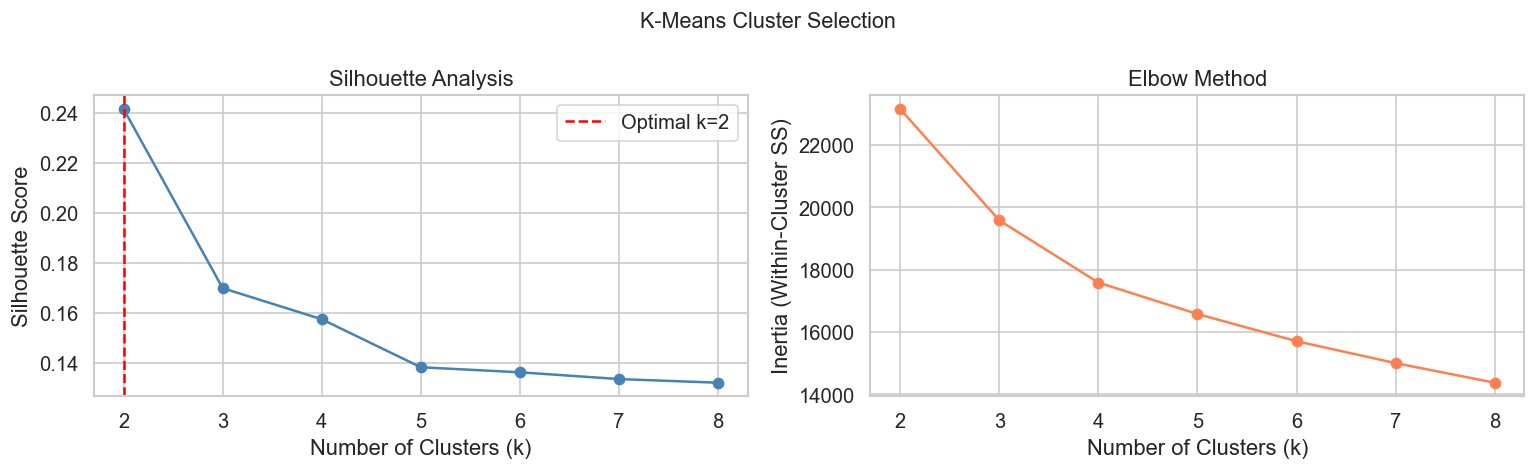

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].plot(list(sil_scores.keys()), list(sil_scores.values()), marker='o', color='steelblue')
axes[0].axvline(best_k, color='red', linestyle='--', label=f'Optimal k={best_k}')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].set_title('Silhouette Analysis')
axes[0].legend()

axes[1].plot(list(inertias.keys()), list(inertias.values()), marker='o', color='coral')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Inertia (Within-Cluster SS)')
axes[1].set_title('Elbow Method')

plt.suptitle('K-Means Cluster Selection', fontsize=13)
plt.tight_layout()
plt.savefig('../outputs/clustering_selection.png', bbox_inches='tight')
plt.show()

## 2. Fit Optimal K-Means

In [4]:
km_best = KMeans(n_clusters=best_k, n_init=30, random_state=RANDOM_STATE)
labels  = km_best.fit_predict(X_perf)

# Attach labels to raw features for interpretation
df_cl = X_raw[perf_features].copy()
df_cl['cluster'] = labels
df_cl['fpvi']    = pd.concat([d['y_fpvi_raw_tr'], d['y_fpvi_raw_val'], d['y_fpvi_raw_te']]).reset_index(drop=True)

print('Cluster sizes:')
print(df_cl['cluster'].value_counts().sort_index())

Cluster sizes:
cluster
0     571
1    2229
Name: count, dtype: int64


## 3. Cluster Profiles

In [5]:
profile = df_cl.groupby('cluster').mean().round(2)
print('Mean feature values per cluster:')
print(profile.T)

Mean feature values per cluster:
cluster                   0        1
age                   27.48    28.07
overall_rating        76.86    76.87
potential_rating      82.43    81.34
matches_played        26.71    27.25
goals_per_90           3.19     0.70
assists_per_90         2.51     0.46
minutes_played       513.74  2694.90
rating_gap             5.57     4.47
age_rating_ratio       2.88     2.80
contract_years_left    2.40     2.56
fpvi                  75.37    42.08


In [6]:
# Build cluster label names based on dominant traits
cluster_names = {}
for cid in range(best_k):
    row = profile.loc[cid]
    age   = row.get('age', 25)
    rating = row.get('overall_rating', 75)
    gp90  = row.get('goals_per_90', 0)
    gap   = row.get('rating_gap', 5)

    if age < 22 and rating < 75:
        name = 'Young Prospects'
    elif age < 26 and rating >= 80:
        name = 'Rising Stars'
    elif age >= 30 and rating >= 80:
        name = 'Veterans'
    elif gp90 >= profile['goals_per_90'].quantile(0.7):
        name = 'Goal Scorers'
    elif rating >= profile['overall_rating'].quantile(0.7):
        name = 'Elite Players'
    else:
        name = f'Cluster {cid}'
    cluster_names[cid] = name

df_cl['archetype'] = df_cl['cluster'].map(cluster_names)
print('\nArchetype assignments:', cluster_names)


Archetype assignments: {0: 'Goal Scorers', 1: 'Elite Players'}


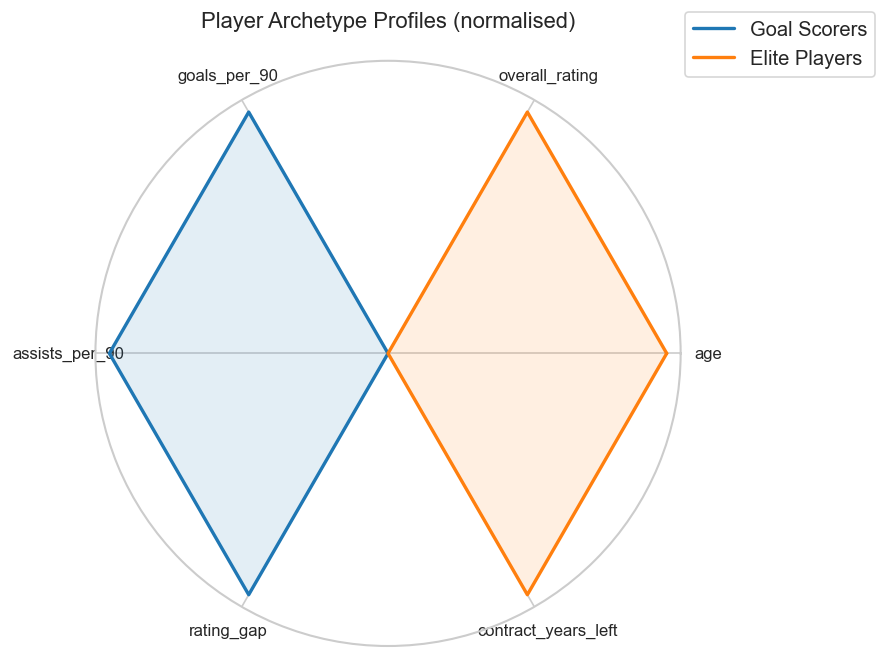

In [7]:
# Radar chart for cluster profiles
radar_features = ['age', 'overall_rating', 'goals_per_90', 'assists_per_90',
                  'rating_gap', 'contract_years_left']
radar_features = [f for f in radar_features if f in df_cl.columns]

# Normalise each feature to 0-1 for radar
radar_data = profile[radar_features].copy()
radar_norm = (radar_data - radar_data.min()) / (radar_data.max() - radar_data.min() + 1e-9)

N = len(radar_features)
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # close the polygon

palette = sns.color_palette('tab10', best_k)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

for cid in range(best_k):
    vals = radar_norm.loc[cid, radar_features].tolist()
    vals += vals[:1]
    ax.plot(angles, vals, color=palette[cid], linewidth=2, label=cluster_names[cid])
    ax.fill(angles, vals, color=palette[cid], alpha=0.12)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_features, size=10)
ax.set_yticks([])
ax.set_title('Player Archetype Profiles (normalised)', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.1))
plt.tight_layout()
plt.savefig('../outputs/clustering_radar.png', bbox_inches='tight')
plt.show()

## 4. PCA 2D Visualisation

PCA explained variance: 24.08% + 22.79% = 46.86%


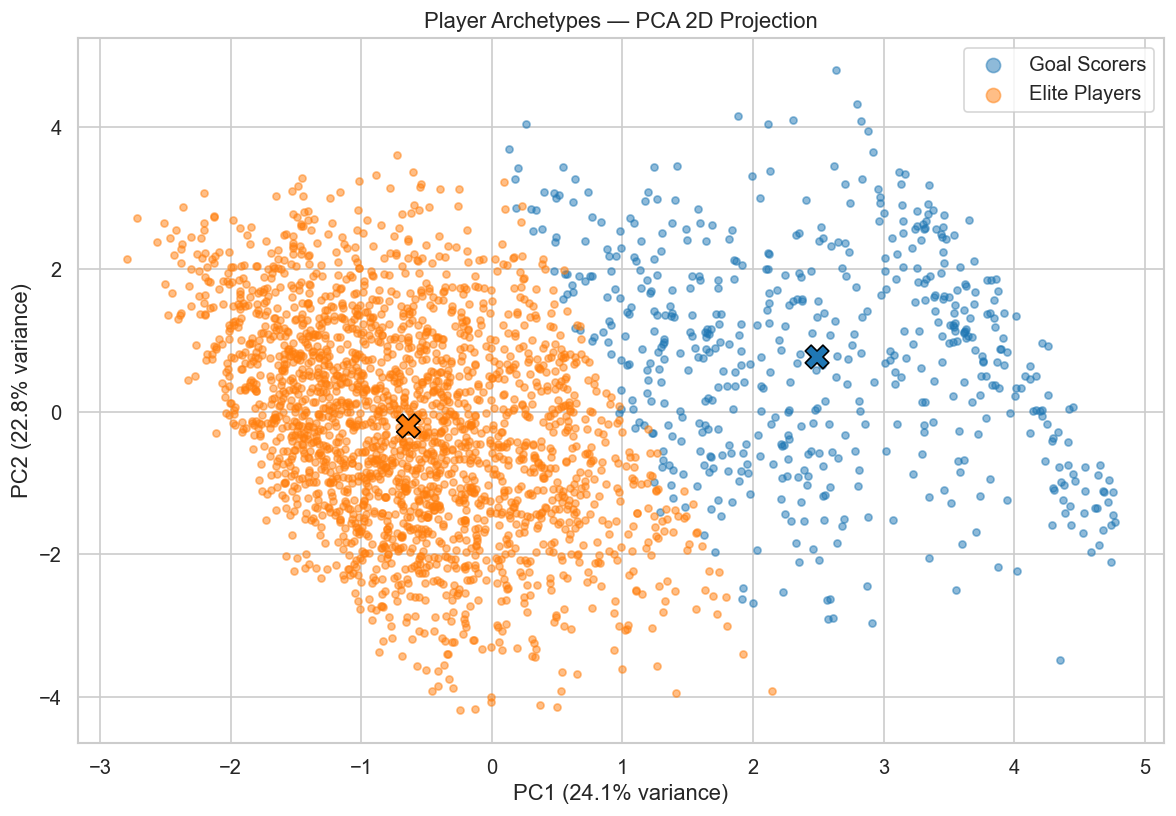

In [8]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)
coords = pca.fit_transform(X_perf)
print(f'PCA explained variance: {pca.explained_variance_ratio_[0]:.2%} + {pca.explained_variance_ratio_[1]:.2%} = {sum(pca.explained_variance_ratio_):.2%}')

fig, ax = plt.subplots(figsize=(10, 7))
for cid, name in cluster_names.items():
    mask = labels == cid
    ax.scatter(coords[mask, 0], coords[mask, 1], label=name,
               s=18, alpha=0.5, color=palette[cid])

# Plot cluster centroids
centroids_pca = pca.transform(km_best.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200,
           c=[palette[i] for i in range(best_k)], edgecolors='black', linewidths=1, zorder=5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax.set_title('Player Archetypes — PCA 2D Projection')
ax.legend(markerscale=2)
plt.tight_layout()
plt.savefig('../outputs/clustering_pca.png', bbox_inches='tight')
plt.show()

## 5. Archetype Feature Distributions

/var/folders/x4/f0qpy7gd3lzdpz89zcyrt3mw0000gn/T/ipykernel_5967/3107081585.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cl, x='archetype', y=feat, order=order, palette='tab10', ax=ax)
/var/folders/x4/f0qpy7gd3lzdpz89zcyrt3mw0000gn/T/ipykernel_5967/3107081585.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cl, x='archetype', y=feat, order=order, palette='tab10', ax=ax)
/var/folders/x4/f0qpy7gd3lzdpz89zcyrt3mw0000gn/T/ipykernel_5967/3107081585.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cl, x='archety

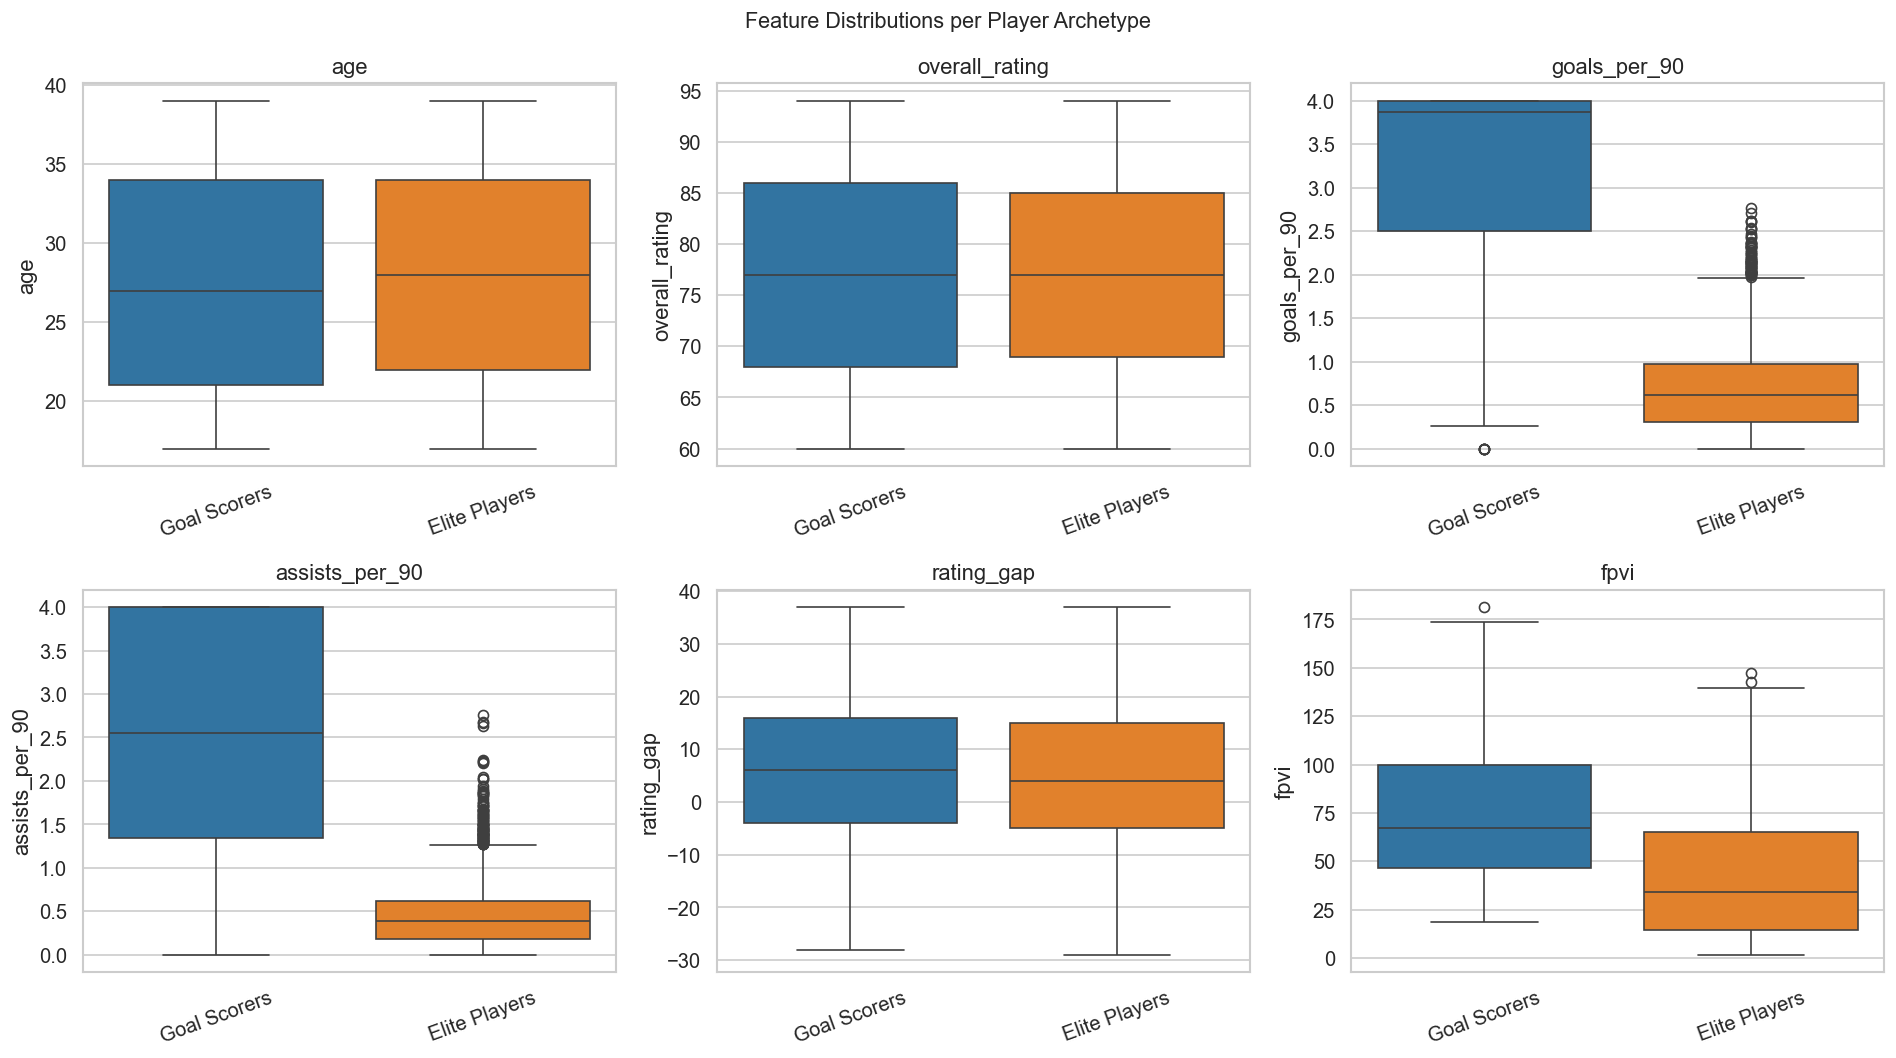

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
box_features = ['age', 'overall_rating', 'goals_per_90', 'assists_per_90', 'rating_gap', 'fpvi']
box_features = [f for f in box_features if f in df_cl.columns]

for ax, feat in zip(axes.flat, box_features):
    order = [cluster_names[i] for i in range(best_k)]
    sns.boxplot(data=df_cl, x='archetype', y=feat, order=order, palette='tab10', ax=ax)
    ax.set_title(feat)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=20)

plt.suptitle('Feature Distributions per Player Archetype', fontsize=13)
plt.tight_layout()
plt.savefig('../outputs/clustering_boxplots.png', bbox_inches='tight')
plt.show()

## 6. Silhouette Plot

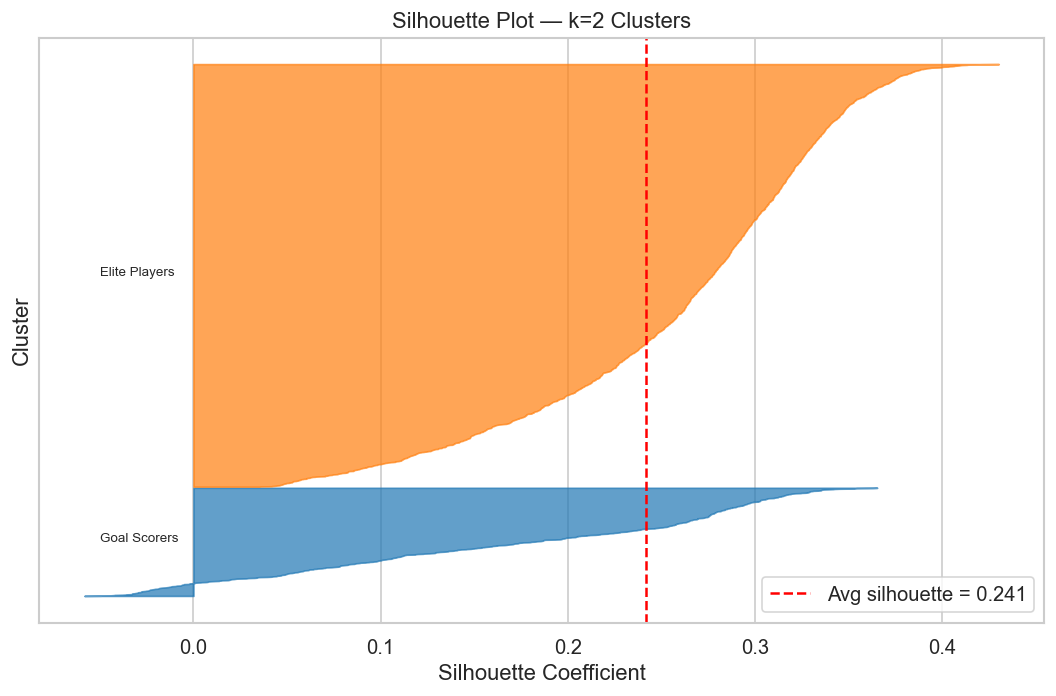

In [10]:
sil_samples = silhouette_samples(X_perf, labels)

fig, ax = plt.subplots(figsize=(9, 6))
y_lower = 10

for cid in range(best_k):
    sil_c = np.sort(sil_samples[labels == cid])
    y_upper = y_lower + len(sil_c)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, sil_c,
                     facecolor=palette[cid], edgecolor=palette[cid], alpha=0.7)
    ax.text(-0.05, y_lower + len(sil_c) / 2, cluster_names[cid], fontsize=8)
    y_lower = y_upper + 5

ax.axvline(sil_scores[best_k], color='red', linestyle='--',
           label=f'Avg silhouette = {sil_scores[best_k]:.3f}')
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.set_yticks([])
ax.set_title(f'Silhouette Plot — k={best_k} Clusters')
ax.legend()
plt.tight_layout()
plt.savefig('../outputs/clustering_silhouette.png', bbox_inches='tight')
plt.show()

## 7. Summary Table

In [11]:
summary = df_cl.groupby('archetype')[radar_features + ['fpvi']].mean().round(2)
summary['n_players'] = df_cl['archetype'].value_counts()
print(summary.T)
summary.to_csv('../outputs/cluster_profiles.csv')

archetype            Elite Players  Goal Scorers
age                          28.07         27.48
overall_rating               76.87         76.86
goals_per_90                  0.70          3.19
assists_per_90                0.46          2.51
rating_gap                    4.47          5.57
contract_years_left           2.56          2.40
fpvi                         42.08         75.37
n_players                  2229.00        571.00


## 8. Clustering Insights

| Archetype | Key Traits |
|---|---|
| Young Prospects | Low age, low current rating but high potential gap |
| Rising Stars | Sub-26, already elite rating — peak market value window |
| Elite Players | High rating, broad contribution stats |
| Goal Scorers | Highest goals-per-90, attackers |
| Veterans | 30+, top rating but diminished upside |

K-Means with k selected by silhouette successfully recovers intuitive player archetypes from purely performance statistics — without using position labels.
